In [1]:
# importing all libraries
import random
import tsplib95
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# All needed functions to create a genetic algorithm and plotting functions
def plot_tour(problem, tour, dataset_name):
    coordinates = [problem.get_display(tour[i]) for i in range(len(tour))]

    x, y = zip(*coordinates)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'o-', mfc='r') # Plot the cities and the path
    plt.title("Best Tour " + dataset_name)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")

    for i in range(len(tour)):
        plt.annotate(tour[i], (x[i], y[i]))

    plt.show()

def create_initial_population(problem, population_size):
    nodes = list(problem.get_nodes())  
    nodes.remove(1)  

    population = []
    for _ in range(population_size):
        tour = random.sample(nodes, len(nodes))
        tour = [1] + tour + [1]
        population.append(tour)

    return population

def calculate_distance(problem, tour):
    total_distance = 0   
   
    for i in range(len(tour) - 1):
        current_city = tour[i]
        next_city = tour[i+1]
        
        distance = problem.get_weight(current_city, next_city)
        
        total_distance += distance
    
    return total_distance 


def fitness(problem, tour):
    return 1 / calculate_distance(problem, tour)


# fitnesses variable is a list that contains the fitness value/score of each tour, 
# selectionFPS - fitness proportionate selection
# The fitness of each individual relative to the population is used to assign a probability of selection. Think of this as the fitness-weighted probability of being selected.
def selectionFPS(population, fitnesses):
    total_fitness = sum(fitnesses)
    probabilities = [f / total_fitness for f in fitnesses] # gets probabilties for each tour

    # chooses two parents randomly. The higher the probability of a parent, the more likely it is to be chosen. 
    parent_indices = np.random.choice(len(population), size=2, replace=False, p=probabilities) 
    selected_population = []
    for i in parent_indices: # switches to a list, is needed later in the program
        selected_population.append(population[i])
    return selected_population

# selectionTS - tournament selection
# A set number of individuals are randomly selected from the population and the one with the highest fitness in the group is chosen as the first parent. This is repeated to chose the second parent.
def selectionTS(population, fitnesses):
    selected_population = []

    # selecting two parents from different randomly selected groups with the highest fitness score
    for _ in range(2):
        parent_indices = random.sample(range(len(population)), 4) # gets 4 random parent indices, needs indices to compare fitness
        parent_indice_highest_fitness = max(parent_indices, key=lambda i: fitnesses[i])
        selected_population.append(population[parent_indice_highest_fitness])

    return selected_population;

def OnePointcrossover(parent1, parent2):
    
    cut = random.randint(1, len(parent1) - 2)
    child = []

    for i in range(cut):
        child.append(parent1[i])

    for city in parent2:
        if city not in child:
            child.append(city)
    child.append(1) # adds the number 1 so the path leads to the starting city
    return child

def uniformCrossover(parent1, parent2):
    
    child = [None] * (len(parent1) - 1)      
    child[0] = 1

    # This for loop may skip some of the parent cities because parent1 may have added one element that exist already in parent2, one city can exist in a chromosome exactly once 
    for i in range(1, len(parent1) - 1):
        if random.random() < 0.5:
            if parent1[i] not in child:
                child[i] = parent1[i]
        else:
            if parent2[i] not in child:
                child[i] = parent2[i]

    remaining_cities = []
    parentCities = parent1 + parent2

    # find the cities that are in parent1 and parent2 but not in child
    for city in parentCities:
        if city not in child:
            remaining_cities.append(city)

    # Fill any remaining None with cities not yet in the child, this enables the child to have the same number of cities as parents
    for i in range(1, len(parent1)-1):
        if child[i] is None:
            child[i] = remaining_cities.pop(0)

    child.append(1)
    return child

# Only one bit (city) is mutated
def BitFlipMutation(tour, mutation_rate):
    if random.random() < mutation_rate:
        i, j = random.sample(range(1, len(tour) - 1), 2)
        tour[i], tour[j] = tour[j], tour[i]
    return tour

def scramblemMutation(tour, mutation_rate):
    if random.random() < mutation_rate:
        i, j = random.sample(range(1, len(tour) - 1), 2)
        #print("original tour: ", tour)
        tour[i:j] = random.sample(tour[i:j], len(tour[i:j])) # randomly swaps the position of the randomly selected indexes
        #print("Index that are swaped: i: ", i,"j: ", j)
        #print("mutated tour: ", tour)
    return tour

def find_best(problem, population):
    best = calculate_distance(problem, population[0])
    tourNr = 0
    for n in range(1, len(population)):
        nextBest = calculate_distance(problem, population[n])
        if nextBest < best:
                tourNr = n
        
    return population[tourNr]

def plot_evolution(best_distances, dataset_name):
    plt.figure(figsize=(10, 6))
    plt.plot(best_distances, marker='o')
    plt.title("Evolution of the Minimum Total Traveling Distance " + dataset_name)
    plt.xlabel("Generation")
    plt.ylabel("Distance")
    plt.grid()
    plt.show()

In [3]:
# The actual function for the genetic algorithm

def genetic_algorithm(problem, population_size, generations, mutation_rate):
    population = create_initial_population(problem, population_size)
    best_distances = []  # List to track the best distance in each generation

    for _ in range(generations):
        fitnesses = []
        for tour in population:
            fitness_value = fitness(problem, tour)
            fitnesses.append(fitness_value)

        bestFromPrevious = find_best(problem, population) # elitism, saves the best tour after each iteration so the evolution continues to be have better paths

        new_population = [bestFromPrevious]
        for _ in range(population_size):
            parent1, parent2 = selectionFPS(population, fitnesses)
            child = OnePointcrossover(parent1, parent2)
            child = scramblemMutation(child, mutation_rate)
            new_population.append(child)
        population = new_population

        current_best_distance = min(calculate_distance(problem, tour) for tour in population)
        best_distances.append(current_best_distance)
        
    best_tour = max(population, key=lambda tour: fitness(problem, tour))
    return best_tour, best_distances

Best solution: [1, 2, 10, 9, 11, 8, 14, 3, 4, 5, 6, 12, 7, 13, 1]
Best solution distance: 3478


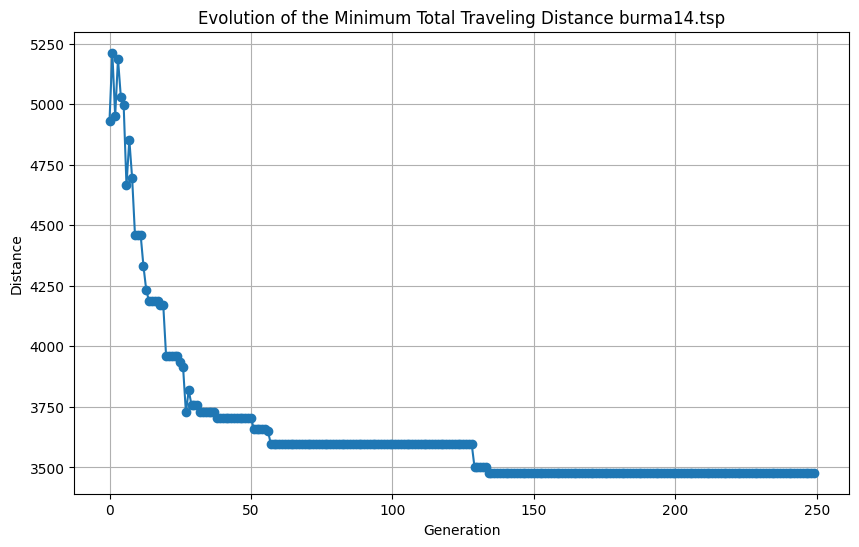

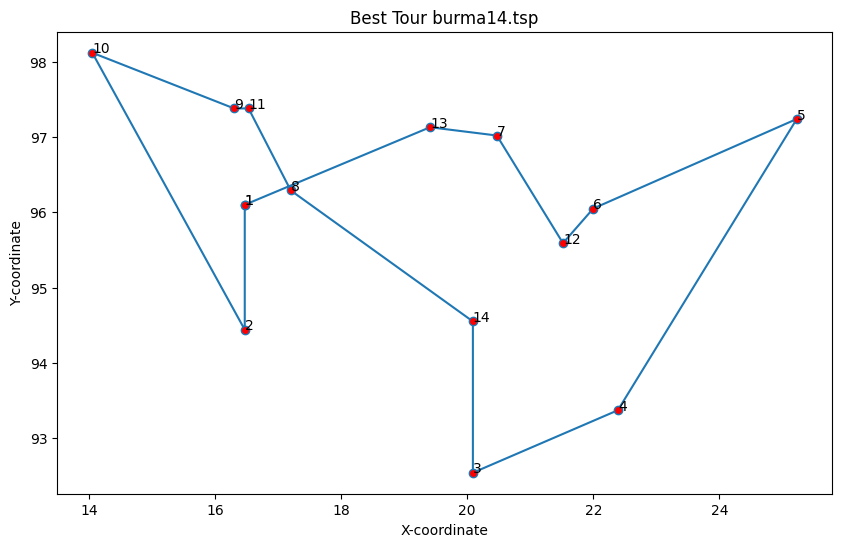

In [21]:

dataset_name = 'burma14.tsp'
file_path = 'datasets/' + dataset_name
problem = tsplib95.load(file_path)

# population = how many solutions will be in a generation
# generations = number of iterations
# mutation_rate = probability of mutation, should experiment with different datasets

best_solution, best_distances = genetic_algorithm(problem, population_size=70, generations=250, mutation_rate=0.1)
best_solution_distance = calculate_distance(problem, best_solution)

print("Best solution:", best_solution)
print("Best solution distance:", best_solution_distance)
plot_evolution(best_distances, dataset_name)
plot_tour(problem, best_solution, dataset_name)